# Basic regression: Predict fuel efficiency

*This notebook is based on the [tutorial notebook](https://www.tensorflow.org/tutorials/keras/regression) provided by TensorFlow.*

---
In a *regression* problem, we aim to predict the output of a continuous value, like a price or a probability. 

This notebook uses the classic [Auto MPG](https://archive.ics.uci.edu/ml/datasets/auto+mpg) Dataset, which you've already encountered in previous notebooks, and builds a model to predict the fuel efficiency of late-1970s and early 1980s automobiles. To do this, we'll provide the model with a description of many automobiles from that time period. This description includes attributes like: cylinders, displacement, horsepower, and weight.

This example uses the `tf.keras` API, see [this guide](https://www.tensorflow.org/guide/keras) for details.

## Setup

In [1]:
import datetime, time, os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Make numpy printouts easier to read.
np.set_printoptions(precision=3, suppress=True)

In [2]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
import tensorflow.keras.layers as kl

print(tf.__version__)

2.15.0


### Setup for TensorBoard

We will use the TensorBoard to visualize some results. You can find more information and the board itself at the end of this notebook, but we will define the path were the information should be stored directly here at the beginning. 

In [3]:
# With this command you can clear any logs from previous runs
# If you want to compare different runs you can skip this cell 
!rm -rf my_logs/

In [4]:
# Define path for new directory 
root_logdir = os.path.join(os.curdir, "my_logs")

In [5]:
# Define function for creating a new folder for each run
def get_run_logdir():
    run_id = time.strftime('run_%d_%m_%Y-%H_%M_%S')
    return os.path.join(root_logdir, run_id)

In [6]:
run_logdir = get_run_logdir()

In [7]:
# Create function for using callbacks; "name" should be the name of the model you use
def get_callbacks(name):
    return tf.keras.callbacks.TensorBoard(run_logdir+name, histogram_freq=1)

## The Auto MPG dataset

The dataset is available from the [UCI Machine Learning Repository](http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data).


### Get the data
First download and import the dataset using pandas:

In [8]:
url = 'http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data'

column_names = ['MPG', 'Cylinders', 'Displacement', 'Horsepower', 'Weight',
                'Acceleration', 'Model Year', 'Origin']

raw_dataset = pd.read_csv(url, names=column_names,
                          na_values='?', comment='\t',
                          sep=' ', skipinitialspace=True)

In [9]:
df = raw_dataset.copy()
df.head()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
0,18.0,8,307.0,130.0,3504.0,12.0,70,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,1


### Clean the data

The `Horsepower` column contains a few unknown values.

In [10]:
df.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

Let's drop those rows to keep this tutorial simple.

In [11]:
df = df.dropna()

Let's check the datatypes and amount of unique values for each column.

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 392 entries, 0 to 397
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   MPG           392 non-null    float64
 1   Cylinders     392 non-null    int64  
 2   Displacement  392 non-null    float64
 3   Horsepower    392 non-null    float64
 4   Weight        392 non-null    float64
 5   Acceleration  392 non-null    float64
 6   Model Year    392 non-null    int64  
 7   Origin        392 non-null    int64  
dtypes: float64(5), int64(3)
memory usage: 27.6 KB


In [13]:
df.nunique()

MPG             127
Cylinders         5
Displacement     81
Horsepower       93
Weight          346
Acceleration     95
Model Year       13
Origin            3
dtype: int64

The `"Origin"` column is really categorical, not numeric. So we have to convert that to a one-hot/dummy:

(Note: You can set up the `keras.Model` to do this kind of transformation for you. That's beyond the scope of this tutorial. See the [preprocessing layers](https://www.tensorflow.org/tutorials/structured_data/preprocessing_layers) or [Loading CSV data](https://www.tensorflow.org/tutorials/load_data/csv) tutorials for examples.)

In [14]:
df['Origin'] = df['Origin'].map({1: 'USA', 2: 'Europe', 3: 'Japan'})

In [15]:
df = pd.get_dummies(df, prefix='', prefix_sep='', dtype='uint8')
df.head()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
0,18.0,8,307.0,130.0,3504.0,12.0,70,0,0,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,0,0,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,0,0,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,0,0,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,0,0,1


### Split the data into train and test

Now we'll split the dataset into a training set and a test set.

We will use the test set in the final evaluation of our models.

In [16]:
df_train = df.sample(frac=0.8, random_state=0)
df_test = df.drop(df_train.index)

### Inspecting the data

Let's have a quick look at the joint distribution of a few pairs of columns from the training set.

Looking at the top row it should be clear that the fuel efficiency (MPG) is a function of all the other parameters. Looking at the other rows it should be clear that they are each functions of eachother.

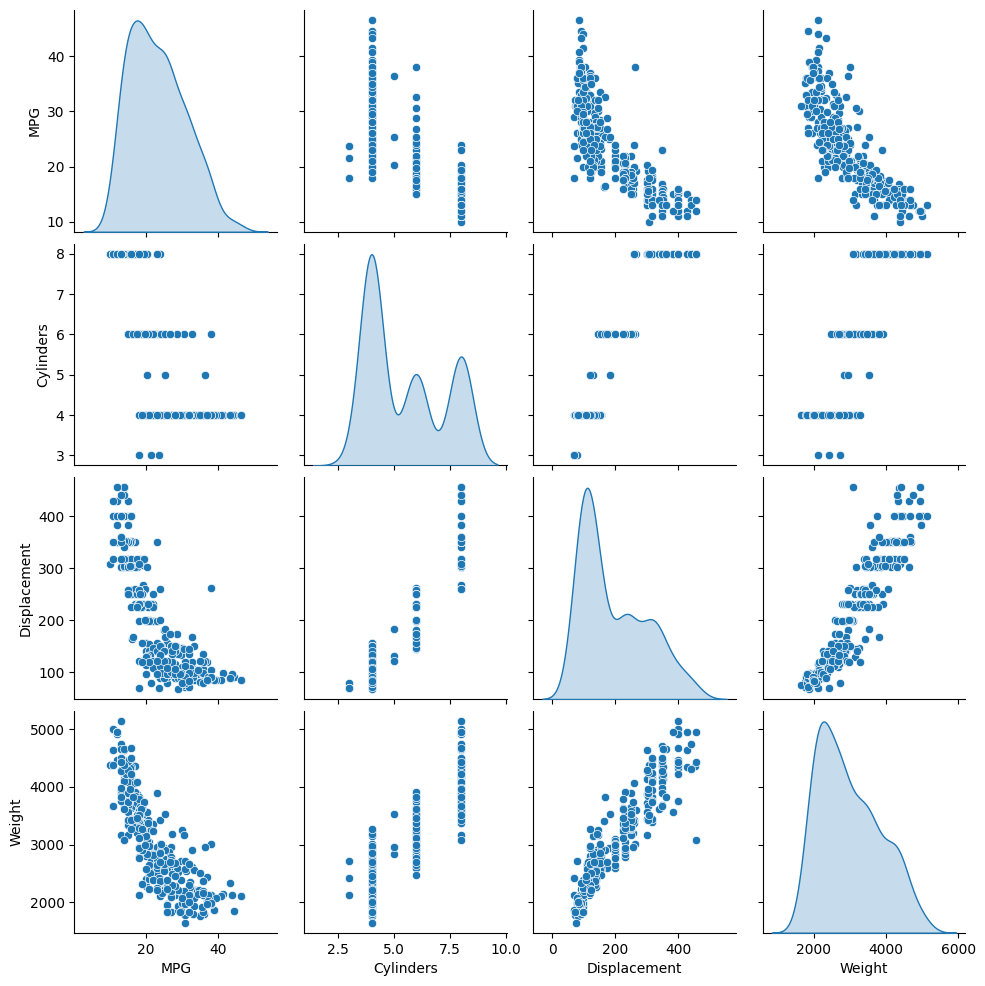

In [17]:
sns.pairplot(df_train[['MPG', 'Cylinders', 'Displacement', 'Weight']], diag_kind='kde');

Also look at the overall statistics, note how each feature covers a very different range:

In [18]:
df_train.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
MPG,314.0,23.310510,7.728652,10.0,17.00,22.0,28.95,46.6
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0


### Split features from labels

Before we can start with the modelling process we need to separate our label from the dataset. This label is the value that we will train the model to predict.

In [19]:
df_train

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
146,28.0,4,90.0,75.0,2125.0,14.5,74,0,0,1
282,22.3,4,140.0,88.0,2890.0,17.3,79,0,0,1
69,12.0,8,350.0,160.0,4456.0,13.5,72,0,0,1
378,38.0,4,105.0,63.0,2125.0,14.7,82,0,0,1
331,33.8,4,97.0,67.0,2145.0,18.0,80,0,1,0
...,...,...,...,...,...,...,...,...,...,...
281,19.8,6,200.0,85.0,2990.0,18.2,79,0,0,1
229,16.0,8,400.0,180.0,4220.0,11.1,77,0,0,1
150,26.0,4,108.0,93.0,2391.0,15.5,74,0,1,0
145,32.0,4,83.0,61.0,2003.0,19.0,74,0,1,0


In [20]:
X_train = df_train.copy()
X_test = df_test.copy()

y_train = X_train.pop('MPG')
y_test = X_test.pop('MPG')

In [21]:
X_train

,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Europe,Japan,USA
146,4,90.0,75.0,2125.0,14.5,74,0,0,1
282,4,140.0,88.0,2890.0,17.3,79,0,0,1
69,8,350.0,160.0,4456.0,13.5,72,0,0,1
378,4,105.0,63.0,2125.0,14.7,82,0,0,1
331,4,97.0,67.0,2145.0,18.0,80,0,1,0
...,...,...,...,...,...,...,...,...,...
281,6,200.0,85.0,2990.0,18.2,79,0,0,1
229,8,400.0,180.0,4220.0,11.1,77,0,0,1
150,4,108.0,93.0,2391.0,15.5,74,0,1,0
145,4,83.0,61.0,2003.0,19.0,74,0,1,0


In [22]:
y_train

146    28.0
282    22.3
69     12.0
378    38.0
331    33.8
       ... 
281    19.8
229    16.0
150    26.0
145    32.0
182    28.0
Name: MPG, Length: 314, dtype: float64

## Sklearn

Before we start using TensorFlow and Keras, let's train a simple `LinearRegression` model from sklearn for comparison. 

In [23]:
# Scaling the data 
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [24]:
# Initalizing and training the model 
lin_reg = LinearRegression()
lin_reg.fit(X_train_scaled, y_train)

LinearRegression()

In [25]:
# Making predictions 
y_pred = lin_reg.predict(X_test_scaled)

In [26]:
# Evaluting model
mae =  mean_absolute_error(y_test, y_pred).round(2)
mse = mean_squared_error(y_test, y_pred).round(2)

print('MAE:', mae)
print('MSE', mse)

MAE: 2.39
MSE 10.17


We'll store the result in a dictionary in order to compare the results of different models in the end.

In [27]:
test_results = {}
test_results['sklearn_model'] =  [mae, mse]

In [28]:
test_results

{'sklearn_model': [2.39, 10.17]}

## Normalization

In the table of statistics it's easy to see how different the ranges of each feature are.

In [29]:
X_train.describe().transpose()[['mean', 'std']]

,mean,std
Cylinders,5.477707,1.699788
Displacement,195.318471,104.331589
Horsepower,104.869427,38.096214
Weight,2990.251592,843.898596
Acceleration,15.559236,2.789230
Model Year,75.898089,3.675642
Europe,0.178344,0.383413
Japan,0.197452,0.398712
USA,0.624204,0.485101


It is good practice to normalize features that use different scales and ranges. 

One reason this is important is because the features are multiplied by the model weights. So the scale of the outputs and the scale of the gradients are affected by the scale of the inputs. 

Although a model *might* converge without feature normalization, normalization makes training much more stable. 

### The Normalization layer
The `preprocessing.Normalization` layer is a clean and simple way to build that preprocessing into your model.

The first step is to create the layer:

In [30]:
normalizer = kl.Normalization()

Then, fit the state of the preprocessing layer to the data by calling `Normalization.adapt`

In [31]:
normalizer.adapt(X_train.values) # adapt expect an array

2026-02-05 15:40:13.913233: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2 Pro
2026-02-05 15:40:13.913268: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 32.00 GB
2026-02-05 15:40:13.913277: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 10.67 GB
2026-02-05 15:40:13.913309: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2026-02-05 15:40:13.913322: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
2026-02-05 15:40:14.004512: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


This calculates the mean and variance, and stores them in the layer. 

In [32]:
normalizer.mean.numpy()

array([[   5.478,  195.318,  104.869, 2990.252,   15.559,   75.898,
           0.178,    0.197,    0.624]], dtype=float32)

When the layer is called it returns the input data, with each feature independently normalized. We can have a look at the first training instance and compare the original and normalized features:

In [33]:
first = X_train[:1]*1.

with np.printoptions(precision=2, suppress=True):
    print('First example:', first)
    print()
    print('Normalized:', normalizer(first.values).numpy())

First example:      Cylinders  Displacement  Horsepower  Weight  Acceleration  Model Year  \
146        4.0          90.0        75.0  2125.0          14.5        74.0   

     Europe  Japan  USA  
146     0.0    0.0  1.0  

Normalized: [[-0.87 -1.01 -0.79 -1.03 -0.38 -0.52 -0.47 -0.5   0.78]]


## Linear regression

Before building a DNN (deep neural network) model, let's start with a linear regression.

### One Variable

We'll start easy with a single-variable linear regression, to predict `MPG` from `Horsepower`.

Training a model with `tf.keras` typically starts by defining the model architecture.

In this case we'll use a `keras.Sequential` model. This model represents a sequence of steps. In this case there are two steps:

1. Normalize the input `horsepower`.
2. Apply a linear transformation ($y = mx+b$) to produce 1 output using `layers.Dense`.

The number of _inputs_ can either be set by the `input_shape` argument, or automatically when the model is run for the first time.

1. First create the horsepower `Normalization` layer:

In [34]:
kl.Input(shape=[1,])

<KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'input_1')>

In [35]:
horsepower = np.array(X_train['Horsepower']) # equivalent X_train['Horsepower'].values

horsepower_normalizer = kl.Normalization(input_shape = [1,], axis= None)
horsepower_normalizer.adapt(horsepower)

2. Then we'll build the sequential model:

In [36]:
horsepower_model = tf.keras.Sequential([
    horsepower_normalizer,
    layers.Dense(units=1)
])

# We can print a summary of the model architecture with the following line:
horsepower_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_1 (Normaliza  (None, 1)                 3         
 tion)                                                           
                                                                 
 dense (Dense)               (None, 1)                 2         
                                                                 
Total params: 5 (24.00 Byte)
Trainable params: 2 (8.00 Byte)
Non-trainable params: 3 (16.00 Byte)
_________________________________________________________________


This model will predict `MPG` from `Horsepower`.

Run the untrained model on the first 10 horse-power values. The output won't be good, but you'll see that it has the expected shape, `(10,1)`:

In [37]:
horsepower_model.predict(horsepower[:10]).shape

1/1 [==============================] - 0s 52ms/step


(10, 1)

In [38]:
horsepower_model.predict(horsepower[:10])

1/1 [==============================] - 0s 10ms/step


array([[ 0.696],
       [ 0.393],
       [-1.284],
       [ 0.975],
       [ 0.882],
       [ 0.346],
       [ 1.045],
       [ 0.882],
       [ 0.23 ],
       [ 0.393]], dtype=float32)

Once the model is built, configure the training procedure using the `Model.compile()` method. The most important arguments to compile are the `loss` and the `optimizer` since these define what will be optimized (`mean_absolute_error`) and how (using the `optimizers.Adam`). We'll also define the `metrics` to use the `mean_squared_error`.

In [39]:
horsepower_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
    loss=['mae'],
    metrics=['mse'])

Once the training is configured, use `Model.fit()` to execute the training:

In [40]:
#%%time
history = horsepower_model.fit(
    df_train['Horsepower'], y_train,
    epochs=100,
    # suppress logging (if you want to see the output for the different epochs set the value to 1)
    verbose=0,
    # Calculate validation results on 20% of the training data
    validation_split = 0.2,
    # Store information for TensorBoard
    callbacks=get_callbacks("horsepower_model"))

2026-02-05 15:40:14.613654: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


Visualize the model's training progress using the stats stored in the `history` object.

In [41]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch

# Show results from first 5 epochs
hist.head() 

,loss,mse,val_loss,val_mse,epoch
0,22.868288,571.537842,22.931847,573.818787,0
1,22.063885,534.795898,22.132099,538.739685,1
2,21.263784,500.889526,21.332125,504.056671,2
3,20.463604,467.526367,20.532141,470.638947,3
4,19.665421,435.100403,19.731831,437.250427,4


In [42]:
# Show results from last 5 epochs (loss and val_loss decreased)
hist.tail()

,loss,mse,val_loss,val_mse,epoch
95,3.805877,25.496836,4.177980,25.223608,95
96,3.802584,25.510872,4.187595,25.316065,96
97,3.807145,25.626984,4.194082,25.398111,97
98,3.802180,25.547682,4.181079,25.283154,98
99,3.804780,25.487736,4.169987,25.192875,99


In [43]:
def plot_loss(history):
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.ylim([0, 10])
    plt.xlabel('Epoch')
    plt.ylabel('Error [MPG]')
    plt.legend()
    plt.grid(True)

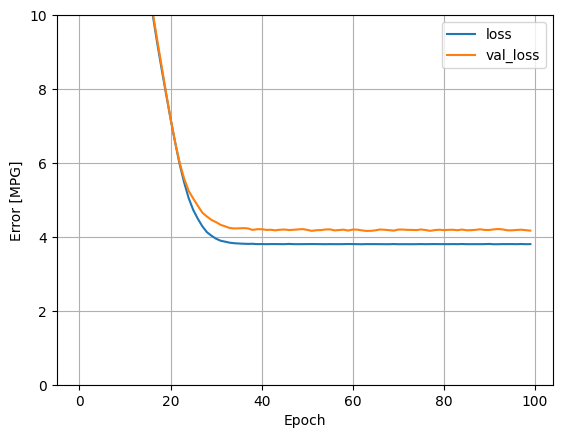

In [44]:
plot_loss(history)

We'll store the results on the test set for later:

In [45]:
test_results['horsepower_model'] = horsepower_model.evaluate(
    X_test['Horsepower'],
    y_test, verbose=0)

Since this is a single variable regression it's easy to look at the model's predictions as a function of the input:

In [46]:
# We'll predict the MPG for 251 different values for horsepower 
x = tf.linspace(0.0, 250, 251)
y = horsepower_model.predict(x)

8/8 [==============================] - 0s 3ms/step


In [47]:
def plot_horsepower(x, y):
    plt.scatter(X_train['Horsepower'], y_train, label='Data')
    plt.plot(x, y, color='k', label='Predictions')
    plt.xlabel('Horsepower')
    plt.ylabel('MPG')
    plt.legend()

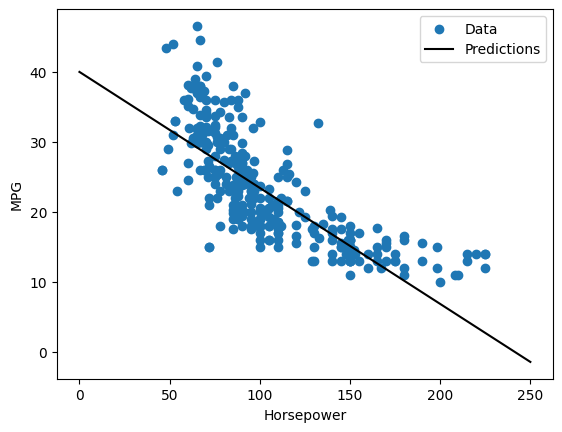

In [48]:
plot_horsepower(x,y)

### Multiple inputs

You can use an almost identical setup to make predictions based on multiple inputs. This model still does the same $y = mx+b$ except that $m$ is a matrix and $b$ is a vector.

This time we'll use the `Normalization` layer that was adapted to the whole dataset.

In [49]:
linear_model = tf.keras.Sequential([
    normalizer,
    layers.Dense(units=1)
])

When you call this model on a batch of inputs, it produces `units=1` outputs for each example.

In [50]:
linear_model.predict(X_train[:10]*1.)

1/1 [==============================] - 0s 33ms/step


array([[ 0.476],
       [ 1.025],
       [ 0.842],
       [ 1.26 ],
       [-0.579],
       [ 0.63 ],
       [-0.837],
       [-1.735],
       [ 0.196],
       [-1.395]], dtype=float32)

When you call the model it's weight matrices will be built. Now you can see that the `kernel` (the $m$ in $y=mx+b$) has a shape of `(9,1)`.

In [51]:
linear_model.layers[1].kernel

<tf.Variable 'dense_1/kernel:0' shape=(9, 1) dtype=float32, numpy=
array([[-0.695],
       [ 0.332],
       [-0.165],
       [ 0.559],
       [-0.508],
       [ 0.331],
       [-0.304],
       [ 0.222],
       [ 0.767]], dtype=float32)>

Use the same `compile` and `fit` calls as for the single input `horsepower` model:

In [52]:
linear_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),
    loss=['mae'],
    metrics=['mse'])

In [53]:
linear_model.compile(
    optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.1),
    loss=['mae'],
    metrics=['mse'])

In [54]:
#%%time
history = linear_model.fit(
    X_train*1., y_train, 
    epochs=100,
    # suppress logging (again: change it to 1 if you want to print more information about each epoch)
    verbose=0,
    # Calculate validation results on 20% of the training data
    validation_split = 0.2,
    # Store information for TensorBoard
    callbacks=get_callbacks("linear_model"))

Using all the inputs achieves a much lower training and validation error than the `horsepower` model: 

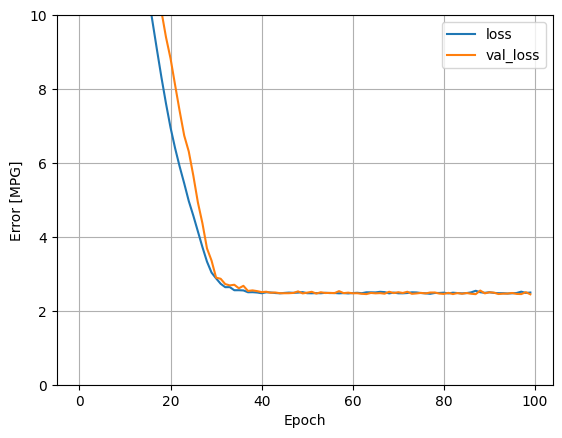

In [55]:
plot_loss(history)

We'll collect the test set result in our previously defined dictionary for later:

In [56]:
test_results['linear_model'] = linear_model.evaluate(
    np.array(X_test).astype('float32'), y_test, verbose=0)

## A DNN regression

The previous section implemented linear models for single and multiple inputs.

This section implements single-input and multiple-input DNN models. The code is basically the same except the model is expanded to include some "hidden"  non-linear layers. The name "hidden" here just means not directly connected to the inputs or outputs.

These models will contain a few more layers than the linear model:

1. The normalization layer.
2. Two hidden, nonlinear, `Dense` layers using the `gelu` nonlinearity.
3. A linear single-output layer.

Both will use the same training procedure so we'll include the `compile` method in the newly defined `build_and_compile_model` function below.

In [57]:
def build_and_compile_model(norm):
    model = keras.Sequential([
        norm,
        layers.Dense(64, activation='gelu'),
        layers.Dense(64, activation='gelu'),
        layers.Dense(1)
    ])

    model.compile(
        optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.001),
        loss=['mae'],
        metrics=['mse'],)
    return model

### One variable

Let's start again with a DNN model for a single input: "Horsepower".

We can use the normalization layer we've created for our first model. 

In [58]:
dnn_horsepower_model = build_and_compile_model(horsepower_normalizer)

This model has quite a few more trainable parameters than the linear models.

In [59]:
dnn_horsepower_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization_1 (Normaliza  (None, 1)                 3         
 tion)                                                           
                                                                 
 dense_2 (Dense)             (None, 64)                128       
                                                                 
 dense_3 (Dense)             (None, 64)                4160      
                                                                 
 dense_4 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4356 (17.02 KB)
Trainable params: 4353 (17.00 KB)
Non-trainable params: 3 (16.00 Byte)
_________________________________________________________________


Let's train the model:

In [60]:
#%%time
history = dnn_horsepower_model.fit(
    X_train['Horsepower'], y_train,
    validation_split=0.2,
    verbose=1, epochs=100,
    callbacks=get_callbacks("dnn_horsepower"))

Epoch 1/100
8/8 [==============================] - 1s 48ms/step - loss: 23.1471 - mse: 596.9555 - val_loss: 23.6005 - val_mse: 620.8372
Epoch 2/100
8/8 [==============================] - 0s 12ms/step - loss: 23.0212 - mse: 592.5246 - val_loss: 23.4576 - val_mse: 615.9767
Epoch 3/100
8/8 [==============================] - 0s 12ms/step - loss: 22.8787 - mse: 587.7020 - val_loss: 23.2781 - val_mse: 610.1329
Epoch 4/100
8/8 [==============================] - 0s 12ms/step - loss: 22.6878 - mse: 581.3052 - val_loss: 23.0492 - val_mse: 602.5010
Epoch 5/100
8/8 [==============================] - 0s 12ms/step - loss: 22.4471 - mse: 573.1901 - val_loss: 22.7391 - val_mse: 592.6860
Epoch 6/100
8/8 [==============================] - 0s 12ms/step - loss: 22.1075 - mse: 562.2885 - val_loss: 22.3328 - val_mse: 579.8724
Epoch 7/100
8/8 [==============================] - 0s 12ms/step - loss: 21.6673 - mse: 548.5118 - val_loss: 21.7952 - val_mse: 563.9428
Epoch 8/100
8/8 [==============================]

This model does slightly better than the linear-horsepower model.

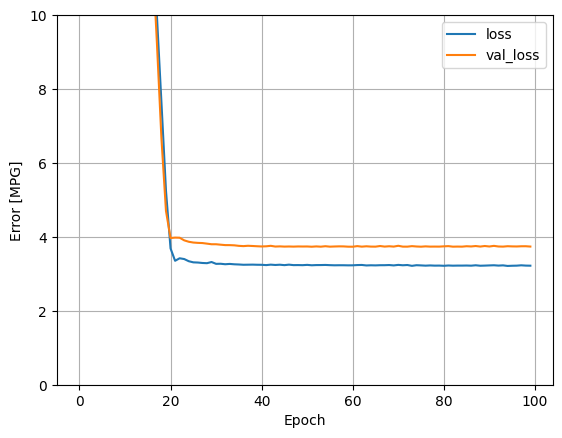

In [61]:
plot_loss(history)

If you plot the predictions as a function of `Horsepower`, you'll see how this model takes advantage of the nonlinearity provided by the hidden layers:

In [62]:
x = tf.linspace(0.0, 250, 251)
y = dnn_horsepower_model.predict(x)

8/8 [==============================] - 0s 6ms/step


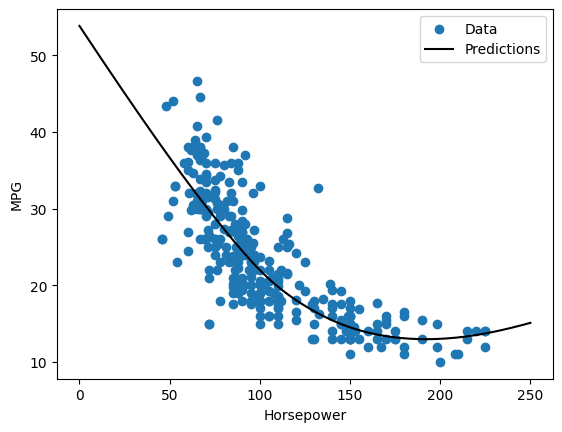

In [63]:
plot_horsepower(x, y)

We'll also collect the results on the test set, for later:

In [64]:
test_results['dnn_horsepower_model'] = dnn_horsepower_model.evaluate(
    X_train['Horsepower'], y_train,
    verbose=0)

### Full model

If you repeat this process using all the inputs it slightly improves the performance on the validation dataset.

In [65]:
dnn_model = build_and_compile_model(normalizer)
dnn_model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizati  (None, 9)                 19        
 on)                                                             
                                                                 
 dense_5 (Dense)             (None, 64)                640       
                                                                 
 dense_6 (Dense)             (None, 64)                4160      
                                                                 
 dense_7 (Dense)             (None, 1)                 65        
                                                                 
Total params: 4884 (19.08 KB)
Trainable params: 4865 (19.00 KB)
Non-trainable params: 19 (80.00 Byte)
_________________________________________________________________


In [66]:
#%%time
history = dnn_model.fit(
    X_train*1., y_train,
    validation_split=0.2,
    verbose=0, epochs=100,
    callbacks=get_callbacks("dnn_model"))

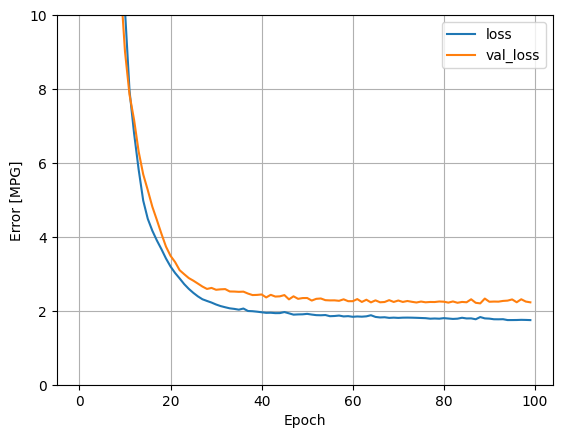

In [67]:
plot_loss(history)

Collect the results on the test set:

In [68]:
test_results['dnn_model'] = dnn_model.evaluate(X_test, y_test, verbose=0)

## Performance

Now that all the models are trained let's check the test-set performance and compare how they performed:

In [69]:
pd.DataFrame(test_results, index=['Mean absolute error [MPG]', 'Mean squared error [MPG]']).T

,Mean absolute error [MPG],Mean squared error [MPG]
sklearn_model,2.390000,10.170000
horsepower_model,3.644899,21.557596
linear_model,2.464101,12.218361
dnn_horsepower_model,3.318871,20.423328
dnn_model,1.736291,5.961003


These results match the validation error seen during training.

### Make predictions

Finally, predict have a look at the errors made by the model when making predictions on the test set:

3/3 [==============================] - 0s 15ms/step


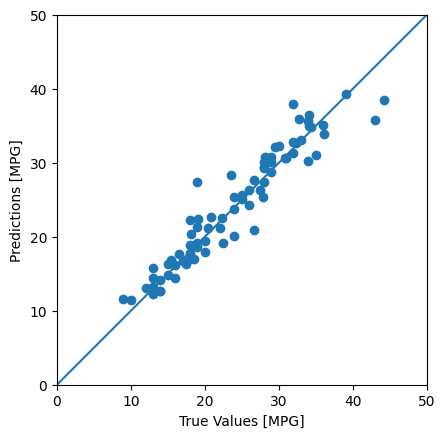

In [70]:
y_pred = dnn_model.predict(X_test).flatten()

a = plt.axes(aspect='equal')
plt.scatter(y_test, y_pred)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
lims = [0, 50]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims, lims)

It looks like the model predicts reasonably well. 

Now take a look at the error distribution:

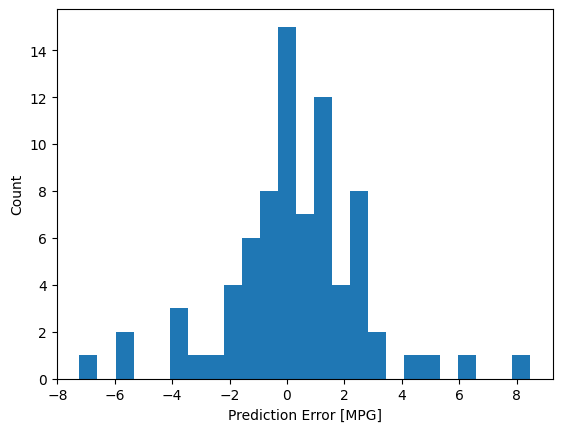

In [71]:
error = y_pred - y_test
plt.hist(error, bins=25)
plt.xlabel('Prediction Error [MPG]')
_ = plt.ylabel('Count')

If you're happy with the model you can save it for later use:

In [72]:
dnn_model.save('dnn_model')

INFO:tensorflow:Assets written to: dnn_model/assets


INFO:tensorflow:Assets written to: dnn_model/assets


If you reload the model, it will give you identical outputs:

In [73]:
reloaded = tf.keras.models.load_model('dnn_model')

test_results['reloaded'] = reloaded.evaluate(
    X_test, y_test, verbose=0)

In [74]:
pd.DataFrame(test_results, index=['Mean absolute error [MPG]', 'Mean squared error [MPG]']).T

,Mean absolute error [MPG],Mean squared error [MPG]
sklearn_model,2.390000,10.170000
horsepower_model,3.644899,21.557596
linear_model,2.464101,12.218361
dnn_horsepower_model,3.318871,20.423328
dnn_model,1.736291,5.961003
reloaded,1.736291,5.961003


## Conclusion

This notebook introduced a few techniques to handle a regression problem. Here are a few more tips that may help:

* [Mean Squared Error (MSE)](https://www.tensorflow.org/api_docs/python/tf/losses/MeanSquaredError) and [Mean Absolute Error (MAE)](https://www.tensorflow.org/api_docs/python/tf/losses/MeanAbsoluteError) are common loss functions used for regression problems. Mean Absolute Error is less sensitive to outliers. Different loss functions are used for classification problems.
* Similarly, evaluation metrics used for regression differ from classification.
* When numeric input data features have values with different ranges, each feature should be scaled independently to the same range.
* Overfitting is a common problem for DNN models, it wasn't a problem for this tutorial. See the [overfit and underfit](https://www.tensorflow.org/tutorials/keras/overfit_and_underfit) tutorial for more help with this.


---
## TensorBoard

In machine learning, to improve something you often need to be able to measure it. TensorBoard is a tool for providing the measurements and visualizations needed during the machine learning workflow. It enables tracking experiment metrics like loss and accuracy, visualizing the model graph, projecting embeddings to a lower dimensional space, and much more.

TensorBoard can be used directly within a notebook in Colab and Jupyter. This can be helpful for sharing results, integrating TensorBoard into existing workflows, and using TensorBoard without installing anything locally.

You can find a nice introductory notebook [here](https://www.tensorflow.org/tensorboard/get_started).

When you are running this NB in a browster and the tensorboard cannot be displayed: If you are using Safari, try to switch to Google Chrome and run it again.

### Example using TensorBoard

When training with Keras's `.fit()`, adding the `tf.keras.callbacks.TensorBoard` callback ensures that logs are created and stored. Additionally, enable histogram computation every epoch with histogram_freq=1 (this is turned off by default).

We've saved the logs in a timestamped subdirectory to allow easy selection of different training runs.

In [75]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

You can start TensorBoard within the notebook using magics. At the end of the command you need to specify the path where the log files are saved.

In [76]:
%tensorboard --logdir=./my_logs

The tensorboard will be available at http://localhost:6006/